In [ ]:
# ---------------------------------------
# Imports & Device Configuration
# ---------------------------------------
# OS & file handling, image I/O
import os
import cv2
from PIL import Image

# PyTorch core, neural nets, optimizers
import torch
import torch.nn as nn
import torch.optim as optim

# For hyperparameter grid loops
import itertools

# Data handling & plotting
import pandas as pd
import matplotlib.pyplot as plt


# PyTorch data utilities & vision models/transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms, datasets

# Select Apple MPS (Metal) if available, else CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [ ]:
# ---------------------------------------
# Face-Cropped Dataset Definition
# ---------------------------------------
# Custom Dataset that:
#  1) Loads images via ImageFolder
#  2) Detects & crops the first face with OpenCV Haar cascade
#  3) Applies any torchvision transforms
class FaceCroppedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Wrap an ImageFolder under the hood
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        # Haar cascade XML file for frontal-face detection
        self.face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image & label
        path, label = self.dataset.samples[idx]
        image = cv2.imread(path)

        # Convert to grayscale for face detection
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        # Crop first detected face, or fallback to full image
        if len(faces) > 0:
            x, y, w, h = faces[0]
            face = image[y:y+h, x:x+w]
        else:
            face = image  # fallback if no face detected

        # Convert BGR→RGB and to PIL for transforms
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = Image.fromarray(face)

        # Apply any augmentations / normalization
        if self.transform:
            face = self.transform(face)

        return face, label


# ---------------------------------------
# DataLoader Factory
# ---------------------------------------
# Constructs train & test DataLoaders, given a data directory.
def get_dataloaders(data_dir, image_size=(224, 224), batch_size=32):
    # Training augmentations: random crop, flip, color jitter
    train_transform = transforms.Compose([
        transforms.Lambda(lambda x: x.convert("RGB")), # ensure 3-channel
        transforms.RandomResizedCrop(image_size[0], scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Validation/test: deterministic resize + normalize
    test_transform = transforms.Compose([
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Instantiate datasets
    train_dataset = FaceCroppedDataset(os.path.join(data_dir, "train"), transform=train_transform)
    test_dataset = FaceCroppedDataset(os.path.join(data_dir, "test"), transform=test_transform)

    # Wrap with DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Return loaders + class list + test transform (for inference)
    return train_loader, test_loader, train_dataset.dataset.classes, test_transform

In [ ]:
# -----------------------------------------------
# Model Definition – TunedEfficientNetB0
# -----------------------------------------------
# This class loads a pre-trained EfficientNet-B0 backbone (ImageNet weights)
# and replaces its default classification head with a custom two-layer MLP:
#   Dropout → Linear(hidden_size) → ReLU → Dropout → Linear(num_classes)
class TunedEfficientNetB0(nn.Module):
    def __init__(self, num_classes, hidden_size, dropout_rate):
        super().__init__()
        # Load EfficientNet-B0 backbone with pretrained ImageNet weights
        self.effnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

        # Inspect the original classifier to get the incoming feature dimension
        #    EfficientNet_B0.classifier is [Dropout, Linear(in_features, 1000)]
        in_features = self.effnet.classifier[1].in_features

        # Build a new classifier head:
        #    - Apply dropout for regularization
        #    - Project features down to `hidden_size` dimensions
        #    - Apply ReLU activation
        #    - Apply another dropout
        #    - Project to `num_classes` outputs (emotion categories)
        self.effnet.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        """
        Forward pass simply delegates to the EfficientNet backbone,
        which now ends in our custom classifier.
        """
        return self.effnet(x)

In [ ]:
# ---------------------------------------
# Training & Evaluation Routines
# ---------------------------------------
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs, device):
    """
    - Trains for num_epochs
    - After each epoch, evaluates on val_loader
    - Returns best validation accuracy
    """
    best_val_acc = 0.0
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
        # validation step
        val_acc = evaluate_model(model, val_loader, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            
    return best_val_acc

def evaluate_model(model, loader, device):
    """
    - Runs inference over loader
    - Returns classification accuracy
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    return correct / total


In [ ]:
# -------------------------------
# Hyperparameter Tuning Settings
# -------------------------------
hidden_sizes    = [256, 512]
dropout_rates   = [0.3, 0.4, 0.5]
learning_rates  = [0.001, 0.0001]
optimizers_choice = ['adam', 'sgd']

data_dir = "FER-2013"
train_loader, val_loader, classes, _ = get_dataloaders(data_dir, image_size=(224, 224), batch_size=32)
num_classes = len(classes)
print("Classes:", classes)

Classes: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
# ----------------------------------------
# Hyperparameter Grid Search for FER-Model
# ----------------------------------------
# Defines search space; runs train_model() on each config;
# records results in a list of dicts.
results = []
best_overall_val_acc = 0.0
best_model_state = None
best_params = None
num_epochs = 5

for hidden_size, dropout_rate, lr, opt_name in itertools.product(
    hidden_sizes, dropout_rates, learning_rates, optimizers_choice):
    
    print(f"\nConfig: hidden_size={hidden_size}, dropout_rate={dropout_rate}, lr={lr}, optimizer={opt_name}")
    
    model = TunedEfficientNetB0(num_classes=num_classes,
                                hidden_size=hidden_size,
                                dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Select optimizer instance
    if opt_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    val_acc = train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs, device)
    print(f"Validation Accuracy: {val_acc:.4f}")
    
    results.append({
        "hidden_size": hidden_size,
        "dropout_rate": dropout_rate,
        "learning_rate": lr,
        "optimizer": opt_name,
        "accuracy": val_acc
    })
    
    if val_acc > best_overall_val_acc:
        best_overall_val_acc = val_acc
        best_params = {
            "hidden_size": hidden_size,
            "dropout_rate": dropout_rate,
            "learning_rate": lr,
            "optimizer": opt_name
        }
        best_model_state = model.state_dict()


Config: hidden_size=256, dropout_rate=0.3, lr=0.001, optimizer=adam


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/kasundodanwala/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100.0%


Epoch 1/5, Validation Accuracy: 0.6021
Epoch 2/5, Validation Accuracy: 0.6280
Epoch 3/5, Validation Accuracy: 0.6303
Epoch 4/5, Validation Accuracy: 0.6496
Epoch 5/5, Validation Accuracy: 0.6536
Validation Accuracy: 0.6536

Config: hidden_size=256, dropout_rate=0.3, lr=0.001, optimizer=sgd
Epoch 1/5, Validation Accuracy: 0.2509
Epoch 2/5, Validation Accuracy: 0.2516
Epoch 3/5, Validation Accuracy: 0.2568
Epoch 4/5, Validation Accuracy: 0.2986
Epoch 5/5, Validation Accuracy: 0.3472
Validation Accuracy: 0.3472

Config: hidden_size=256, dropout_rate=0.3, lr=0.0001, optimizer=adam
Epoch 1/5, Validation Accuracy: 0.6117
Epoch 2/5, Validation Accuracy: 0.6526
Epoch 3/5, Validation Accuracy: 0.6714
Epoch 4/5, Validation Accuracy: 0.6755
Epoch 5/5, Validation Accuracy: 0.6859
Validation Accuracy: 0.6859

Config: hidden_size=256, dropout_rate=0.3, lr=0.0001, optimizer=sgd
Epoch 1/5, Validation Accuracy: 0.2503
Epoch 2/5, Validation Accuracy: 0.2516
Epoch 3/5, Validation Accuracy: 0.2522
Epoch 4


All Hyperparameter Tuning Results for FER-2013:
    hidden_size  dropout_rate  learning_rate optimizer  accuracy
0           256           0.3         0.0010      adam  0.653601
1           256           0.3         0.0010       sgd  0.347248
2           256           0.3         0.0001      adam  0.685864
3           256           0.3         0.0001       sgd  0.252158
4           256           0.4         0.0010      adam  0.668035
5           256           0.4         0.0010       sgd  0.281873
6           256           0.4         0.0001      adam  0.682892
7           256           0.4         0.0001       sgd  0.238857
8           256           0.5         0.0010      adam  0.658129
9           256           0.5         0.0010       sgd  0.317815
10          256           0.5         0.0001      adam  0.674402
11          256           0.5         0.0001       sgd  0.255837
12          512           0.3         0.0010      adam  0.652894
13          512           0.3         0.0

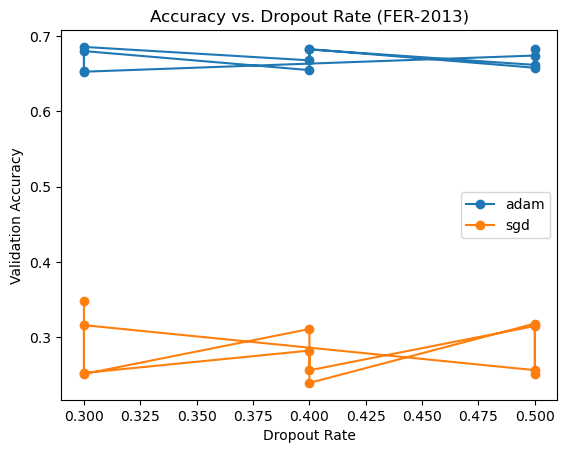

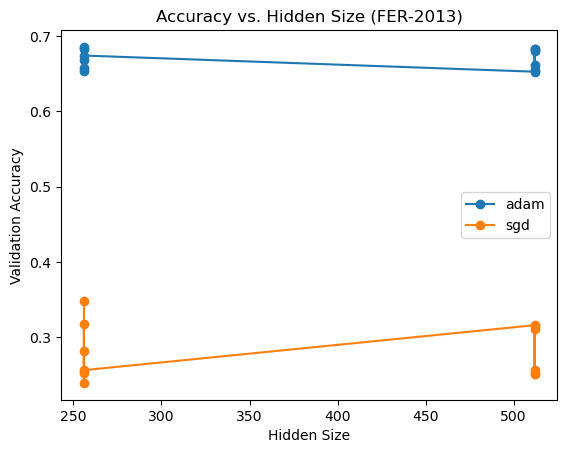

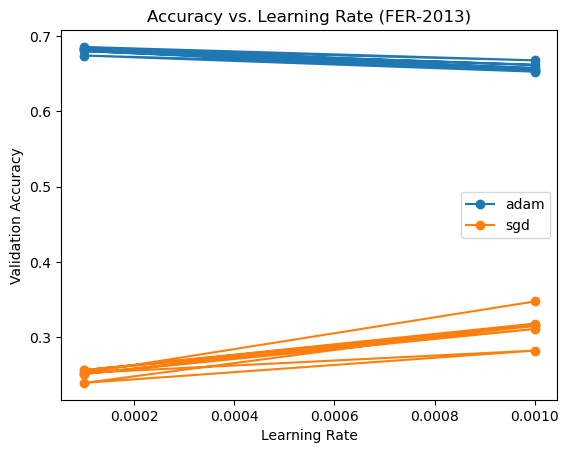

In [ ]:
# ---------------------------------------------
# Plotting Hyperparameter Results for FER-Model
# ---------------------------------------------

results_df = pd.DataFrame(results)
print("\nAll Hyperparameter Tuning Results for FER-2013:")
print(results_df)

# Accuracy vs. Dropout Rate
plt.figure()
for opt in results_df['optimizer'].unique():
    subset = results_df[results_df['optimizer'] == opt]
    plt.plot(subset['dropout_rate'], subset['accuracy'], marker='o', label=f"{opt}")
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy vs. Dropout Rate (FER-2013)')
plt.legend()
plt.show()

# Accuracy vs. Hidden Size
plt.figure()
for opt in results_df['optimizer'].unique():
    subset = results_df[results_df['optimizer'] == opt]
    plt.plot(subset['hidden_size'], subset['accuracy'], marker='o', label=f"{opt}")
plt.xlabel('Hidden Size')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy vs. Hidden Size (FER-2013)')
plt.legend()
plt.show()

# Accuracy vs. Learning Rate
plt.figure()
for opt in results_df['optimizer'].unique():
    subset = results_df[results_df['optimizer'] == opt]
    plt.plot(subset['learning_rate'], subset['accuracy'], marker='o', label=f"{opt}")
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy vs. Learning Rate (FER-2013)')
plt.legend()
plt.show()

Best Hyperparameter Tuning Results for FER-2013:
    hidden_size  dropout_rate  learning_rate optimizer  accuracy
2           256           0.3         0.0001      adam  0.685864

In [8]:
data_dir = "RAF-DB"
train_loader, val_loader, classes, _ = get_dataloaders(data_dir, image_size=(224, 224), batch_size=32)
num_classes = len(classes)
print("Classes:", classes)

Classes: ['angry', 'fear', 'happy', 'nuetral', 'sad', 'surprise']


In [ ]:
# ----------------------------------------
# Hyperparameter Tuning Loop for RAF-Model
# ----------------------------------------

results = []
best_overall_val_acc = 0.0
best_model_state = None
best_params = None
num_epochs = 5

for hidden_size, dropout_rate, lr, opt_name in itertools.product(
    hidden_sizes, dropout_rates, learning_rates, optimizers_choice):
    
    print(f"\nConfig: hidden_size={hidden_size}, dropout_rate={dropout_rate}, lr={lr}, optimizer={opt_name}")
    
    model = TunedEfficientNetB0(num_classes=num_classes,
                                hidden_size=hidden_size,
                                dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()
    
    if opt_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    val_acc = train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs, device)
    print(f"Validation Accuracy: {val_acc:.4f}")
    
    results.append({
        "hidden_size": hidden_size,
        "dropout_rate": dropout_rate,
        "learning_rate": lr,
        "optimizer": opt_name,
        "accuracy": val_acc
    })
    
    if val_acc > best_overall_val_acc:
        best_overall_val_acc = val_acc
        best_params = {
            "hidden_size": hidden_size,
            "dropout_rate": dropout_rate,
            "learning_rate": lr,
            "optimizer": opt_name
        }
        best_model_state = model.state_dict()


Config: hidden_size=256, dropout_rate=0.3, lr=0.001, optimizer=adam
Epoch 1/5, Validation Accuracy: 0.7940
Epoch 2/5, Validation Accuracy: 0.8009
Epoch 3/5, Validation Accuracy: 0.8102
Epoch 4/5, Validation Accuracy: 0.8446
Epoch 5/5, Validation Accuracy: 0.8284
Validation Accuracy: 0.8446

Config: hidden_size=256, dropout_rate=0.3, lr=0.001, optimizer=sgd
Epoch 1/5, Validation Accuracy: 0.4072
Epoch 2/5, Validation Accuracy: 0.4072
Epoch 3/5, Validation Accuracy: 0.4092
Epoch 4/5, Validation Accuracy: 0.4109
Epoch 5/5, Validation Accuracy: 0.4140
Validation Accuracy: 0.4140

Config: hidden_size=256, dropout_rate=0.3, lr=0.0001, optimizer=adam
Epoch 1/5, Validation Accuracy: 0.7331
Epoch 2/5, Validation Accuracy: 0.7930
Epoch 3/5, Validation Accuracy: 0.8373
Epoch 4/5, Validation Accuracy: 0.8435
Epoch 5/5, Validation Accuracy: 0.8607
Validation Accuracy: 0.8607

Config: hidden_size=256, dropout_rate=0.3, lr=0.0001, optimizer=sgd
Epoch 1/5, Validation Accuracy: 0.3164
Epoch 2/5, Valid


All Hyperparameter Tuning Results for RAF-DB:
    hidden_size  dropout_rate  learning_rate optimizer  accuracy
0           256           0.3         0.0010      adam  0.844567
1           256           0.3         0.0010       sgd  0.414030
2           256           0.3         0.0001      adam  0.860729
3           256           0.3         0.0001       sgd  0.415406
4           256           0.4         0.0010      adam  0.862448
5           256           0.4         0.0010       sgd  0.415062
6           256           0.4         0.0001      adam  0.848006
7           256           0.4         0.0001       sgd  0.403714
8           256           0.5         0.0010      adam  0.847318
9           256           0.5         0.0010       sgd  0.420564
10          256           0.5         0.0001      adam  0.854195
11          256           0.5         0.0001       sgd  0.408184
12          512           0.3         0.0010      adam  0.859697
13          512           0.3         0.001

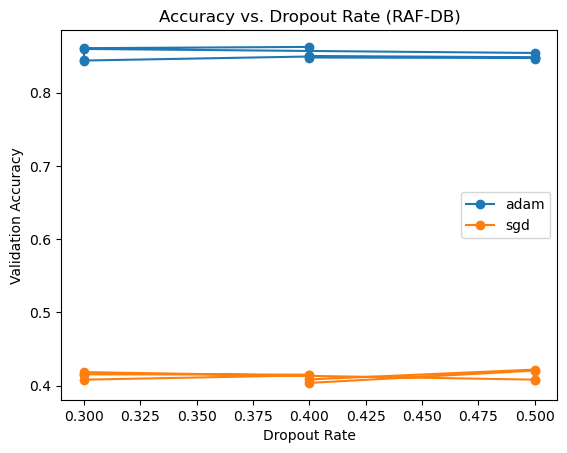

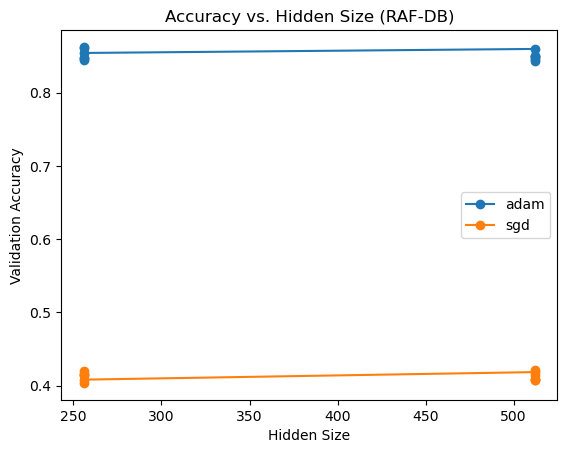

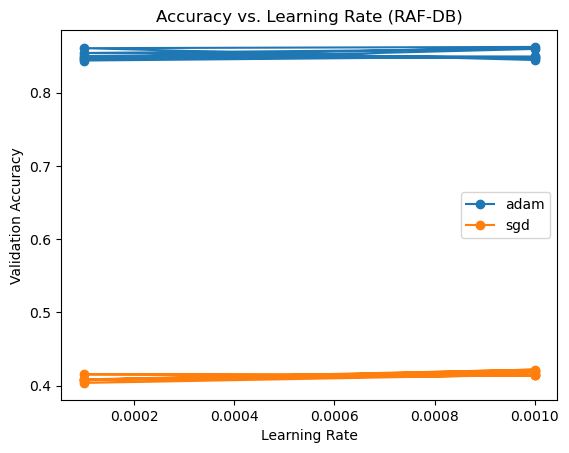

In [ ]:
# ---------------------------------------------
# Plotting Hyperparameter Results for RAF-Model
# ---------------------------------------------

results_df = pd.DataFrame(results)
print("\nAll Hyperparameter Tuning Results for RAF-DB:")
print(results_df)

# Accuracy vs. Dropout Rate
plt.figure()
for opt in results_df['optimizer'].unique():
    subset = results_df[results_df['optimizer'] == opt]
    plt.plot(subset['dropout_rate'], subset['accuracy'], marker='o', label=f"{opt}")
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy vs. Dropout Rate (RAF-DB)')
plt.legend()
plt.show()

# Accuracy vs. Hidden Size
plt.figure()
for opt in results_df['optimizer'].unique():
    subset = results_df[results_df['optimizer'] == opt]
    plt.plot(subset['hidden_size'], subset['accuracy'], marker='o', label=f"{opt}")
plt.xlabel('Hidden Size')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy vs. Hidden Size (RAF-DB)')
plt.legend()
plt.show()

# Accuracy vs. Learning Rate
plt.figure()
for opt in results_df['optimizer'].unique():
    subset = results_df[results_df['optimizer'] == opt]
    plt.plot(subset['learning_rate'], subset['accuracy'], marker='o', label=f"{opt}")
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy vs. Learning Rate (RAF-DB)')
plt.legend()
plt.show()

Best Hyperparameter Tuning Results for RAF-DB:
    hidden_size  dropout_rate  learning_rate optimizer  accuracy
4           256           0.4         0.0010      adam  0.862448